In [1]:
import os
import time
import math
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
from functools import partial

# import tensorflow as tf
# import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# tf.test.is_gpu_available()

In [4]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [5]:
def compute_stats(values):
    mean = sum(values) / len(values)
    var_unb = sum((v - mean) ** 2 for v in values) / (len(values) - 1)
    return mean, math.sqrt(var_unb)


def compute_stats_np(values):
    mean = np.mean(values)
    var_unb = np.sum((values - mean) ** 2) / (len(values) - 1)
    return mean, math.sqrt(var_unb)

In [6]:
NRUNS = 5

### F1 - simple gauss

In [7]:
import scipy.stats as spt

target = 1
target_precision = 1e-3

norm_dist = spt.norm(loc=0.5, scale=0.01)

prefix = 'f1'

target_dict = {
    'f1_d2': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 2,
    'f1_d4': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 4,
    'f1_d6': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 6,
    'f1_d8': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 8,
}
target_dict

{'f1_d2': 1.0, 'f1_d4': 1.0, 'f1_d6': 1.0, 'f1_d8': 1.0}

In [8]:
sigma = 0.01
alpha = sigma * math.sqrt(2)


def f1_np(x, ndims):
    pre = 1.0 / (alpha * math.sqrt(math.pi)) ** ndims
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

def f1(x, ndims):
    pre = 1.0 / (alpha * math.sqrt(math.pi)) ** ndims
    exponent = -1 * sum((t - .5) ** 2 for t in x) / alpha ** 2
    return pre * math.exp(exponent)

In [9]:
dim2func_dict = {
    2: partial(f1_np, ndims=2),
    4: partial(f1_np, ndims=4),
    6: partial(f1_np, ndims=6),
    8: partial(f1_np, ndims=8),
}
dim2func_dict

{2: functools.partial(<function f1_np at 0x0000021A3ED128B8>, ndims=2),
 4: functools.partial(<function f1_np at 0x0000021A3ED128B8>, ndims=4),
 6: functools.partial(<function f1_np at 0x0000021A3ED128B8>, ndims=6),
 8: functools.partial(<function f1_np at 0x0000021A3ED128B8>, ndims=8)}

#### Uniform

In [11]:
%%time
np.random.seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2, 4, 6, 8]
neval_lst = list(map(int, [1e4, 1e5, 1e6, 1e7]))
run_lst = list(range(1, NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand_np = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  neval={neval}')

            time_a = time.time()
            data = np.random.random(size=(neval, ndims))
            gen_time = time.time() - time_a
            
            time_a = time.time()
            values = integrand_np(data)
            mean, std = compute_stats_np(values)
            error = std / math.sqrt(neval)
            eval_time = time.time() - time_a
            
            result_means.append(mean)
            result_sdevs.append(error)
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)

run=1
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=10000000
ndims=8  neval=10000
ndims=8  neval=100000
ndims=8  neval=1000000
ndims=8  neval=10000000
run=2
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=10000000
ndims=8  neval=10000
ndims=8  neval=100000
ndims=8  neval=1000000
ndims=8  neval=10000000
run=3
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=1

In [17]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)
temp_df['total_time'] = temp_df.result_gen_time + temp_df.result_eval_time

In [18]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc,total_time
0,2,10000,8.695566e-01,2.389052e-01,0.000000,0.000998,1,1.00,0.000998
1,2,100000,9.867377e-01,8.570580e-02,0.001993,0.004987,1,0.71,0.006981
2,2,1000000,9.695893e-01,2.725944e-02,0.012965,0.059840,1,0.82,0.072805
3,2,10000000,1.005652e+00,8.950975e-03,0.129653,0.603386,1,0.82,0.733040
4,4,10000,7.461582e-06,7.322690e-06,0.008976,0.004987,1,0.36,0.013963
...,...,...,...,...,...,...,...,...,...
75,6,10000000,8.914884e-04,8.006489e-04,0.397936,0.900592,5,0.69,1.298528
76,8,10000,4.047839e-95,4.047839e-95,0.030918,0.007978,5,0.21,0.038896
77,8,100000,2.671273e-40,2.670691e-40,0.005984,0.008976,5,0.60,0.014961
78,8,1000000,3.975166e-43,3.975166e-43,0.052858,0.098737,5,0.65,0.151595


In [19]:
os.makedirs('result/02_NaiveNumpy', exist_ok=True)
temp_df.to_csv('result/02_NaiveNumpy/f1_uniform_new.csv', index=False)

In [2]:
# temp_df = pd.read_csv('result/02_NaiveNumpy/f1_uniform_new.csv')

In [21]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'total_time',
                       'eval_time_perc']]

In [22]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,total_time,eval_time_perc
0,2,10000,1.040895e+00,2.928311e-01,0.035306,0.007181,0.042487,0.334
1,2,100000,1.003141e+00,8.898626e-02,0.001396,0.005186,0.006582,0.788
2,2,1000000,9.861288e-01,2.782691e-02,0.013364,0.060439,0.073803,0.816
3,2,10000000,1.005230e+00,8.957117e-03,0.131449,0.605182,0.736630,0.820
4,4,10000,4.526741e-06,4.498963e-06,0.009575,0.005585,0.015160,0.366
5,4,100000,1.711524e-01,1.688144e-01,0.002992,0.006383,0.009375,0.682
6,4,1000000,9.199027e-01,4.572134e-01,0.026330,0.075797,0.102127,0.742
7,4,10000000,1.190456e+00,2.900121e-01,0.263495,0.767548,1.031043,0.744
8,6,10000,6.736172e-32,5.259553e-32,0.019747,0.007779,0.027526,0.286
9,6,100000,5.357065e-17,5.357065e-17,0.003989,0.007979,0.011968,0.668


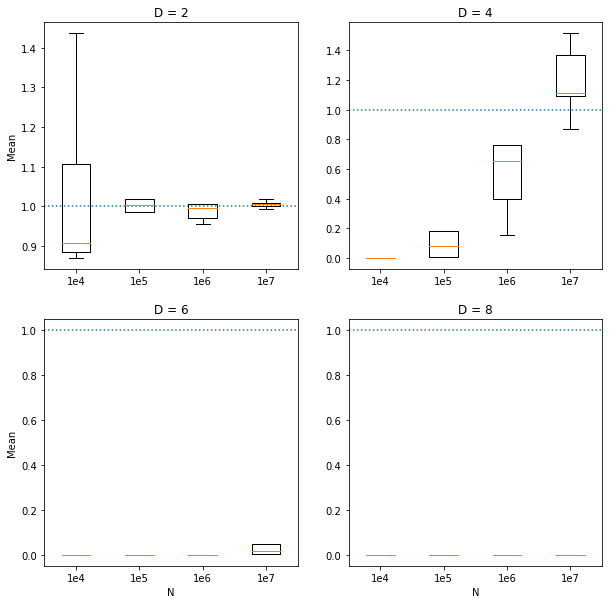

In [23]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(10,10))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(2,2,i+1)
    ax.axhline(y=target_dict[f'{prefix}_d{ndims}'], linestyle=':')
    ax.set_title(f'D = {ndims}')
    if i > 1:
        ax.set_xlabel('N')
    if i % 2 == 0:
        ax.set_ylabel('Mean')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=False)

In [24]:
# fig.savefig('result/02_NaivePython/f1_uniform_mean_new.png')

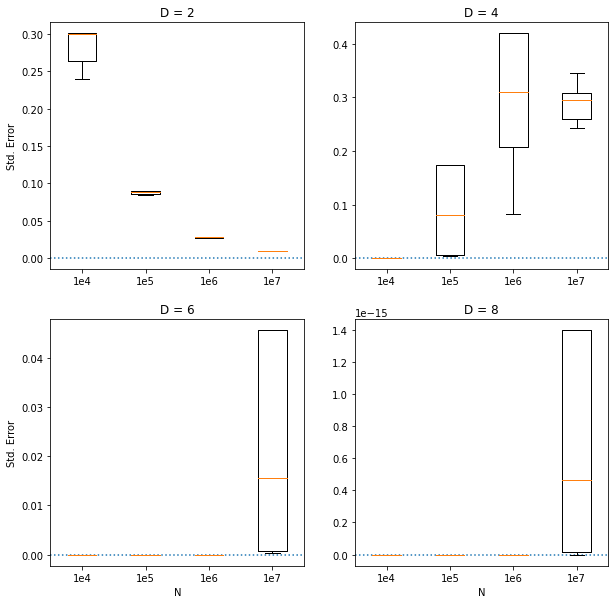

In [25]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(10,10))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(2,2,i+1)
    ax.axhline(y=0, linestyle=':')
    ax.set_title(f'D = {ndims}')
    if i > 1:
        ax.set_xlabel('N')
    if i % 2 == 0:
        ax.set_ylabel('Std. Error')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=False)

In [26]:
# fig.savefig('result/02_NaivePython/f1_uniform_error_new.png')

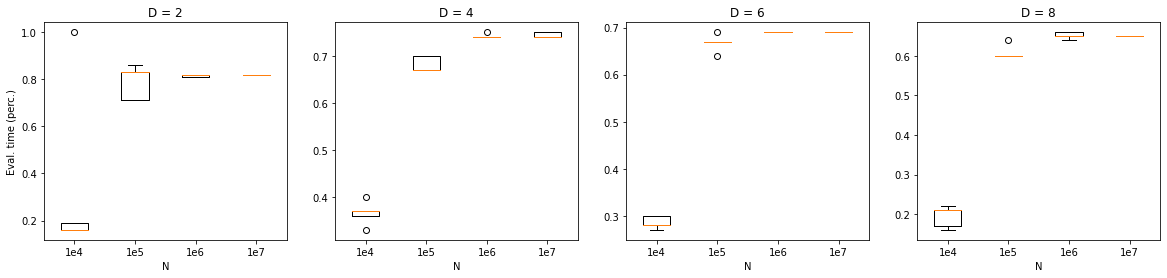

In [27]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Eval. time (perc.)')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

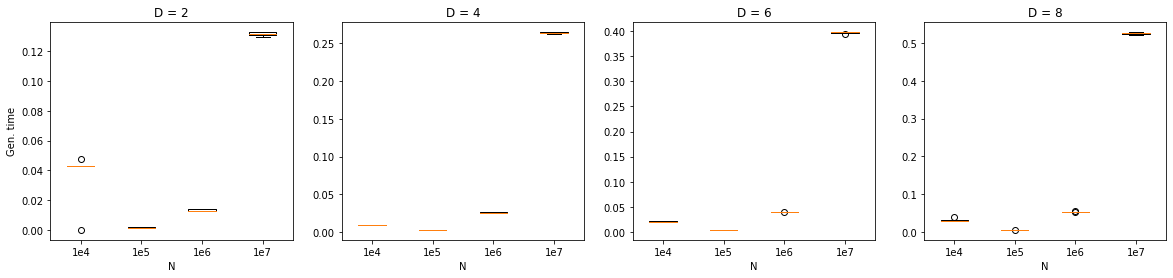

In [28]:
# result_gen_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_gen_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Gen. time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

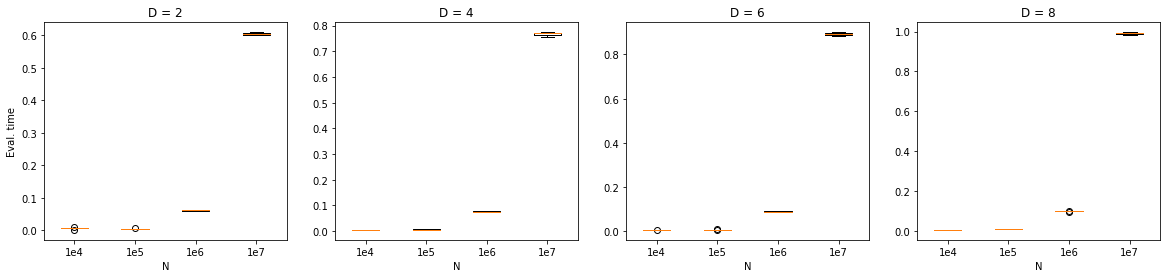

In [29]:
# result_eval_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_eval_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Eval. time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

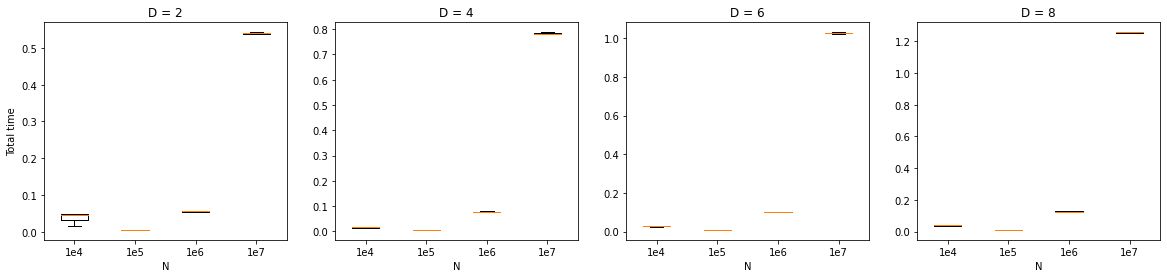

In [31]:
# total_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].copy()
    plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
    plot_data = plot_data.groupby('neval')['total_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Total time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

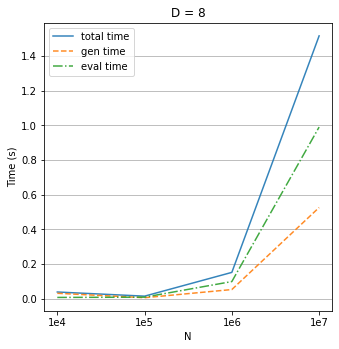

In [30]:
# total_time (D8) vs samples

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])

plot_data = temp_df[temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['total_time'].apply(lambda x: x.tolist())
ax.set_title(f'D = {ndims}')
ax.set_xlabel('N')
ax.set_ylabel('Time (s)')
# ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None);
locs = ax.get_xticks()
ax.set_xticks(ax.get_xticks(), labels=['', '1e4', '1e5', '1e6', '1e7', ''])
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='-', alpha=.9, label='total time')

plot_data = temp_df[temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['result_gen_time'].apply(lambda x: x.tolist())
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='dashed', alpha=.9, label='gen time')

plot_data = temp_df[temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['result_eval_time'].apply(lambda x: x.tolist())
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='dashdot', alpha=.9, label='eval time')

ax.legend()
ax.grid(axis='y')

In [31]:
# fig.savefig('result/02_NaivePython/f1_uniform_time_new.png', bbox_inches='tight')

#### Time

In [4]:
time_df = temp_df[temp_df.neval == int(1e7)].groupby('ndims').agg([np.mean, np.std])

In [5]:
time_df

neval        result_mean                 result_sdev  \
             mean  std          mean           std          mean   
ndims                                                              
2      10000000.0  0.0  1.005230e+00  9.443815e-03  8.957117e-03   
4      10000000.0  0.0  1.190456e+00  2.531023e-01  2.900121e-01   
6      10000000.0  0.0  9.635598e-02  1.808853e-01  9.533614e-02   
8      10000000.0  0.0  4.012332e-12  8.970795e-12  4.012331e-12   

                    result_gen_time           result_eval_time            \
                std            mean       std             mean       std   
ndims                                                                      
2      5.197555e-05        0.131449  0.001300         0.605182  0.003412   
4      4.093869e-02        0.263495  0.000835         0.767548  0.007073   
6      1.793694e-01        0.397138  0.001300         0.893212  0.006409   
8      8.970795e-12        0.525794  0.002581         0.989754  0.005926   

      run_num           eval_time_perc           total_time            
         mean       std           mean       std       mean       std  
ndims                                                                  
2         3.0  1.581139          0.820  0.000000   0.736630  0.004494  
4         3.0  1.581139          0.744  0.005477   1.031043  0.007770  
6         3.0  1.581139          0.690  0.000000   1.290350  0.007101  
8         3.0  1.581139          0.650  0.000000   1.515548  0.007038

In [7]:
time_df[['result_gen_time', 'result_eval_time', 'total_time']]

result_gen_time           result_eval_time           total_time  \
                 mean       std             mean       std       mean   
ndims                                                                   
2            0.131449  0.001300         0.605182  0.003412   0.736630   
4            0.263495  0.000835         0.767548  0.007073   1.031043   
6            0.397138  0.001300         0.893212  0.006409   1.290350   
8            0.525794  0.002581         0.989754  0.005926   1.515548   

                 
            std  
ndims            
2      0.004494  
4      0.007770  
6      0.007101  
8      0.007038

In [9]:
t = time_df[['result_gen_time', 'result_eval_time']]
t['total_mean'] = time_df['result_gen_time']['mean'] + time_df['result_eval_time']['mean']
t['total_std'] = (time_df['result_gen_time']['std']**2 + time_df['result_eval_time']['std']**2)**.5

t

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


result_gen_time           result_eval_time           total_mean  \
                 mean       std             mean       std              
ndims                                                                   
2            0.131648  0.000997         0.408574  0.001152   0.540221   
4            0.263966  0.000567         0.519272  0.004704   0.783238   
6            0.396606  0.001152         0.629982  0.004498   1.026587   
8            0.529251  0.000576         0.725725  0.002303   1.254976   

      total_std  
                 
ndims            
2      0.001523  
4      0.004738  
6      0.004643  
8      0.002374

In [10]:
def temp_print(xx):
    temp_foo = lambda x4: x4[0] + ' ± ' + x4[1] + '\n'
    print(''.join([temp_foo(x.round(3).astype(str))
           for x in xx.values]))
    
temp_print(t[['total_mean', 'total_std']])

0.54 ± 0.002
0.783 ± 0.005
1.027 ± 0.005
1.255 ± 0.002



In [188]:
# results from pure python

time_df

# result_sdev reaches {0.001757, 0.009955, 0.054550, 0.348377} on N = 1e7 samples

neval      result_mean           result_sdev            \
             mean  std        mean       std        mean       std   
ndims                                                                
2      10000000.0  0.0    1.001198  0.001652    0.001757  0.000002   
4      10000000.0  0.0    0.991086  0.005009    0.009955  0.000051   
6      10000000.0  0.0    0.964469  0.010881    0.054550  0.000439   
8      10000000.0  0.0    0.994901  0.164678    0.348377  0.041304   

      result_gen_time           result_eval_time           run_num       \
                 mean       std             mean       std    mean  std   
ndims                                                                     
2            8.856975  0.294607        28.168985  0.115902     2.0  1.0   
4           11.174443  0.163424        31.525340  0.047521     2.0  1.0   
6           14.951008  0.395227        34.955499  0.124870     2.0  1.0   
8           17.394804  0.524048        38.047893  0.084381     2.0  1.0   

      eval_time_perc            
                mean       std  
ndims                           
2           0.756667  0.005774  
4           0.740000  0.000000  
6           0.696667  0.005774  
8           0.686667  0.005774